In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss, mean_absolute_error, classification_report,  precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
import lightgbm as lgb
from lightgbm import LGBMClassifier
#! pip install catboost
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OXGBoostEstimator, H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from catboost import CatBoostClassifier, Pool

In [ ]:
# Load the data from 'BMS_labels.xlsx' into labels_df
labels_df = pd.read_excel('BMS_labels.xlsx')
reduced_labels_df = labels_df.dropna(subset=['file name'])

# Read in CSV
csv_file_path = "autoCalc_parameters_2023-8-30.csv"

autocalc_df = pd.read_csv(csv_file_path)

# Drop empty rows
autocalc_df = autocalc_df.dropna(how='all')

# Extract the number between "cut" and "DLC" from the 'name' column in autoCalc_df
autocalc_df['cut_number'] = autocalc_df['name'].str.extract(r'cut(\d+)DLC')

# Convert the 'cut_number' column to numeric (integer)
autocalc_df['cut_number'] = pd.to_numeric(autocalc_df['cut_number'], errors='coerce')

# Initialize lists to store values from labels_df
direction_values = []
start_frame_values = []
end_frame_values = []
bms_l_values = []
bms_r_values = []

# Convert the 'name' column in autoCalc_df to strings
autocalc_df['name'] = autocalc_df['name'].astype(str)

# Loop through rows in autoCalc_df
for name in autocalc_df['name']:
    # Find the matching 'file name' in reduced_labels_df
    matching_row = reduced_labels_df[reduced_labels_df['file name'].apply(lambda x: name.startswith(x))]

    # Check if a matching row was found
    if not matching_row.empty:
        # Append BMS-L and BMS-R values to lists
        bms_l_values.append(matching_row['BMS-L'].values[-1])
        bms_r_values.append(matching_row['BMS-R'].values[-1])
    else:
        # If no match was found, append NaN values or a default value
        bms_l_values.append(None)  # You can replace None with a default value if needed
        bms_r_values.append(None)  # You can replace None with a default value if needed

# Add the BMS-L and BMS-R columns to autoCalc_df
autocalc_df['BMS-L'] = bms_l_values
autocalc_df['BMS-R'] = bms_r_values

# Loop through rows in autoCalc_df
for cut_number in autocalc_df['cut_number']:
  # Skip rows with missing or 'nan' values in 'cut_number'
  if pd.notna(cut_number):
    # Find the matching row in labels_df based on 'cut_number'
    matching_row = labels_df.loc[cut_number]

    # Check if a matching row was found
    if not matching_row.empty:
        # Append values for "direction," "start frame," and "end frame" to lists
        direction_values.append(matching_row['direction'])
        start_frame_values.append(matching_row['start frame'])
        end_frame_values.append(matching_row['end frame'])
    else:
        # If no match was found, append NaN values or default values
        direction_values.append(None)  # You can replace None with a default value if needed
        start_frame_values.append(None)  # You can replace None with a default value if needed
        end_frame_values.append(None)  # You can replace None with a default value if needed

  else:
    # Handle missing or 'nan' values in 'cut_number' column
    direction_values.append(None)
    start_frame_values.append(None)
    end_frame_values.append(None)

# Add new columns to autoCalc_df with values from labels_df
autocalc_df['direction'] = direction_values
autocalc_df['start frame'] = start_frame_values
autocalc_df['end frame'] = end_frame_values

# Display the resulting merged dataframe
#print(autocalc_df)

In [ ]:
# Data cleaning

# Calculate the percentage of missing values for each column
missing_percentage_per_col = (autocalc_df.isna().sum() / len(autocalc_df)) * 100

# Calculate the percentage of missing values for each row
missing_percentage_per_row = (autocalc_df.isna().sum(axis=1) / len(autocalc_df.columns)) * 100

autocalc_df_cleaned = autocalc_df.replace('', np.nan)

# Calculate the percentage of missing values for each column
clean_missing_percentage_per_col = (autocalc_df_cleaned.isna().sum() / len(autocalc_df_cleaned)) * 100

# Calculate the percentage of missing values for each row
clean_missing_percentage_per_row = (autocalc_df_cleaned.isna().sum(axis=1) / len(autocalc_df_cleaned.columns)) * 100

#print(clean_missing_percentage_per_col)
#print(clean_missing_percentage_per_row)

#print(autocalc_df_cleaned.shape)

In [ ]:
# alt outlier handler (replaces w nan)
# Define a z-score threshold (e.g., ±3 standard deviations)
z_score_threshold = 3

# List of columns to process (exclude the first column if needed)
columns_to_process = autocalc_df_cleaned.columns[1:-3]

# Loop through each column and replace outliers with NaN using .loc
for column_name in columns_to_process:
    z_scores = stats.zscore(autocalc_df_cleaned[column_name])
    outlier_mask = (z_scores < -z_score_threshold) | (z_scores > z_score_threshold)
    autocalc_df_cleaned.loc[outlier_mask, column_name] = np.nan

# Removes this column (column of single values)
autocalc_df_cleaned = autocalc_df_cleaned.drop(columns=['distance_nose_tail_median'])

print(autocalc_df_cleaned.shape)

(180, 154)


In [ ]:
# Distribution of each variable
def distribution(df):
    # Extract all column names except the first one
    columns_to_plot = df.columns[1:]  # Exclude the first column

    # Define the number of rows and columns in the grid
    num_rows = 40
    num_cols = 5


    # Calculate the figure size based on the number of rows and columns
    fig_width = 15  # Adjust the width as needed
    fig_height = 3 * num_rows  # Adjust the height as needed

    # Create a plot with a 10x20 grid of subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(fig_width, fig_height))

    # Loop through the columns and create distribution plots
    for i, column_name in enumerate(columns_to_plot):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        # Remove NA values from the column using dropna()
        data = df[column_name].dropna()

        # Create a histogram with a KDE plot
        sns.histplot(data, ax=ax, kde=True, color='blue')  # You can adjust the color if needed

        ax.set_title(f'Distribution of {column_name}')
        ax.set_xlabel('')

    # Remove any empty subplots
    for i in range(len(columns_to_plot), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    # Adjust layout
    plt.tight_layout()
    plt.show()

#distribution(autocalc_df_cleaned)


In [ ]:
# Drop rows where either 'BMS-L' or 'BMS-R' is missing
autocalc_df_cleaned = autocalc_df_cleaned.dropna(subset=['BMS-L', 'BMS-R'], how='any')

# Reset the index if needed
autocalc_df_cleaned.reset_index(drop=True, inplace=True)

# Assuming you have multiple target columns in autocalc_df_cleaned
target_columns = ['BMS-L', 'BMS-R']  # Replace with your actual target column names

# Define the feature columns (X)
X = autocalc_df_cleaned.drop(columns=['name'] + target_columns)

# Perform one-hot encoding for 'direction'
X = pd.get_dummies(X, columns=['direction'], drop_first=True)

# Define the target columns (y)
y = autocalc_df_cleaned[target_columns]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a dummy classifier as a baseline model
dummy_classifier_L = DummyClassifier(strategy='most_frequent')  # You can also try 'stratified' or 'uniform'

# Fit the baseline model on the training data
dummy_classifier_L.fit(X_train, y_train['BMS-L'])

# Make predictions on the test data using the baseline model
baseline_predictions_L = dummy_classifier_L.predict(X_test)

# Calculate the baseline accuracy
baseline_accuracy_L = accuracy_score(y_test['BMS-L'], baseline_predictions_L)
print(f"Baseline Accuracy: {baseline_accuracy_L}")

dummy_classifier_R = DummyClassifier(strategy='most_frequent')  # You can also try 'stratified' or 'uniform'

# Fit the baseline model on the training data
dummy_classifier_R.fit(X_train, y_train['BMS-R'])

# Make predictions on the test data using the baseline model
baseline_predictions_R = dummy_classifier_R.predict(X_test)

# Calculate the baseline accuracy
baseline_accuracy_R = accuracy_score(y_test['BMS-R'], baseline_predictions_R)
print(f"Baseline Accuracy: {baseline_accuracy_R}")

Baseline Accuracy: 0.19444444444444445
Baseline Accuracy: 0.1111111111111111


In [ ]:
correlation_matrix = autocalc_df_cleaned.corr()

threshold = 0.90  # Adjust this threshold as needed
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            correlated_features.add(colname_i)
            correlated_features.add(colname_j)

print(autocalc_df_cleaned.shape)
autocalc_df_cleaned = autocalc_df_cleaned.drop(columns=correlated_features)
print(autocalc_df_cleaned.shape)

(180, 154)
(180, 117)


<ipython-input-22-65442e53e40d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = autocalc_df_cleaned.corr()


In [ ]:
# Function to calculate and print metrics
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)

# Function to plot ROC curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
# Initialize H2O
h2o.init()

# Split the data into training and testing sets
h2o_X_train, h2o_X_test, h2o_y_train, h2o_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to store models and their respective predictions and reports
models = {}

# Loop over each target variable ('BMS-L' and 'BMS-R')
for target_var in ['BMS-L', 'BMS-R']:
    # Create a new H2OFrame with a single target column for the current target variable
    train_data_h2o = h2o.H2OFrame(
        h2o_X_train.assign(target_variable=h2o_y_train[target_var].tolist())
    )

    # Round the target variable to the nearest integer to make it categorical
    train_data_h2o[target_var] = train_data_h2o[target_variable].round()

    # Define the features by excluding the current target variable
    features = [col for col in train_data_h2o.columns if col != target_var]

    # Set the column names explicitly
    train_data_h2o.set_names(features + [target_var])

    # Train the Random Forest model for the current target variable
    h2o_rf = H2ORandomForestEstimator()
    h2o_rf.train(x=features, y=target_var, training_frame=train_data_h2o)

    # Convert your test data to an H2O Frame
    test_data_h2o = h2o.H2OFrame(h2o_X_test)

    # Make predictions using the trained model
    predictions = h2o_rf.predict(test_data_h2o)

    # Round the predicted labels to the nearest integer
    predicted_labels = predictions['predict'].round().as_data_frame()['predict'].tolist()

    # Calculate evaluation metrics
    actual_labels = h2o_y_test[target_var].round()

    classification_rep = classification_report(actual_labels, predicted_labels)

    print(f"Classification Report for '{target_var}':")
    print(classification_rep)

    # Store the model and its predictions/report in the dictionary
    models[target_var] = {
        'model': h2o_rf,
        'predictions': predicted_labels,
        'report': classification_rep
    }



Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 3 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_unknownUser_kius4f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.148 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [distance_nose_tail_median]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'target_variable': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

Classification Report for 'BMS-L':
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.00      0.00      0.00         2
         2.0       0.67      0.40      0.50         5
         3.0       0.38      0.43      0.40         7
         4.0       0.20      0.33      0.25         3
         5.0       0.17      1.00      0.29         2
         6.0       0.00      0.00      0.00         2
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         6

    accuracy                           0.22        36
   macro avg       0.14      0.22      0.14        36
weighted avg       0.19      0.22      0.18        36

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [distance_nose_tail_median]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Classification Report for 'BMS-R':
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00         2
         3.0       0.17      0.14      0.15         7
         4.0       0.20      0.33      0.25         3
         5.0       0.20      0.50      0.29         4
         6.0       0.20      0.50      0.29         2
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         2
         9.0       0.00      0.00      0.00         6

    accuracy                           0.14        36
   macro avg       0.08      0.15      0.10        36
wei

/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'target_variable': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

In [ ]:
# Logistic Regression - L: 0.0714, R: 0.4286
# X contains your feature data, and y contains multiple target columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model for 'BMS-L'
lr_model_BMS_L = LogisticRegression()
lr_model_BMS_L.fit(X_train, y_train['BMS-L'])  # Train on the 'BMS-L' target

# Make predictions on the test data for 'BMS-L'
lr_y_pred_BMS_L = lr_model_BMS_L.predict(X_test)

# Evaluate the model for 'BMS-L'
lr_accuracy_BMS_L = accuracy_score(y_test['BMS-L'], lr_y_pred_BMS_L)
print(f"Logistic Regression Accuracy for 'BMS-L': {lr_accuracy_BMS_L}")

# Initialize and train a logistic regression model for 'BMS-R'
lr_model_BMS_R = LogisticRegression()
lr_model_BMS_R.fit(X_train, y_train['BMS-R'])  # Train on the 'BMS-R' target

# Make predictions on the test data for 'BMS-R'
lr_y_pred_BMS_R = lr_model_BMS_R.predict(X_test)

# Evaluate the model for 'BMS-R'
lr_accuracy_BMS_R = accuracy_score(y_test['BMS-R'], lr_y_pred_BMS_R)
print(f"Logistic Regression Accuracy for 'BMS-R': {lr_accuracy_BMS_R}")

ValueError: ignored

In [ ]:
# XGBoost - L: 0.5714, R: 0.6429, with blanks - L:0.7222, R: 0.6667
# X contains your feature data, and y contains multiple target columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable 'BMS-L' and 'BMS-R' to integers starting from 0
y_train_encoded_BMS_L = label_encoder.fit_transform(y_train['BMS-L'])
y_test_encoded_BMS_L = label_encoder.transform(y_test['BMS-L'])

y_train_encoded_BMS_R = label_encoder.fit_transform(y_train['BMS-R'])
y_test_encoded_BMS_R = label_encoder.transform(y_test['BMS-R'])

# Initialize and train the XGBoost model for 'BMS-L'
xgb_model_BMS_L = xgb.XGBClassifier(objective="multi:softmax", num_class=8, random_state=42)
xgb_model_BMS_L.fit(X_train, y_train_encoded_BMS_L)  # Train on the encoded 'BMS-L' target

# Initialize and train the XGBoost model for 'BMS-R'
xgb_model_BMS_R = xgb.XGBClassifier(objective="multi:softmax", num_class=8, random_state=42)
xgb_model_BMS_R.fit(X_train, y_train_encoded_BMS_R)  # Train on the encoded 'BMS-R' target

# Make predictions on the test data for 'BMS-L' and 'BMS-R'
xgb_y_pred_BMS_L = xgb_model_BMS_L.predict(X_test)
xgb_y_pred_BMS_R = xgb_model_BMS_R.predict(X_test)

# Inverse transform the encoded predictions to get the original class labels
y_pred_BMS_L = label_encoder.inverse_transform(xgb_y_pred_BMS_L)
y_pred_BMS_R = label_encoder.inverse_transform(xgb_y_pred_BMS_R)

# Evaluate the models for 'BMS-L' and 'BMS-R'
xgb_accuracy_BMS_L = accuracy_score(y_test['BMS-L'], y_pred_BMS_L)
xgb_accuracy_BMS_R = accuracy_score(y_test['BMS-R'], y_pred_BMS_R)

print(f"XGBoost Accuracy for 'BMS-L: {xgb_accuracy_BMS_L}")
print(f"XGBoost Accuracy for 'BMS-R: {xgb_accuracy_BMS_R}")

XGBoost Accuracy for 'BMS-L: 0.6388888888888888
XGBoost Accuracy for 'BMS-R: 0.7777777777777778


LightGBM Accuracy for 'BMS-L': 0.75
LightGBM Accuracy for 'BMS-R': 0.7777777777777778
Metrics for 'BMS-L':
Precision: 0.77
Recall: 0.75
F1 Score: 0.72
Confusion Matrix:
[[1 0 1 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 4 0 1 0 0 0 0 0]
 [0 0 0 6 1 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 3 0]
 [0 0 0 0 0 0 0 0 0 6]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


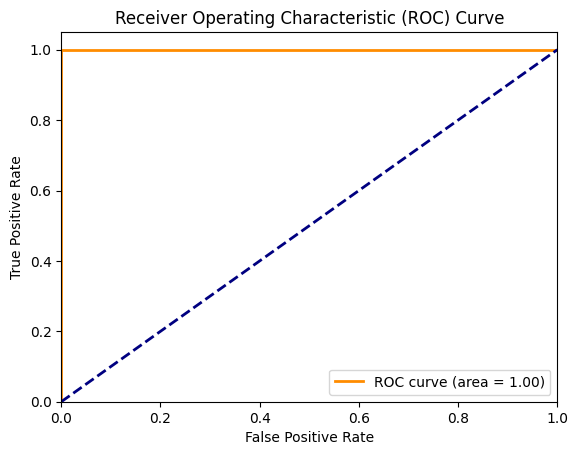

Cross-Validation Metrics for 'BMS-L':
Precision: 0.68
Recall: 0.67
F1 Score: 0.67
Confusion Matrix:
[[ 9  1  1  0  0  0  0  0  0  0]
 [ 2  1  2  0  0  0  0  0  0  0]
 [ 3  0 11  2  0  0  1  0  0  0]
 [ 1  0  2 15  3  2  0  0  0  0]
 [ 0  0  1  6  8  2  1  0  0  0]
 [ 0  0  0  2  0 13  0  0  4  0]
 [ 0  0  0  1  0  0 12  0  3  0]
 [ 0  0  0  0  2  0  0  5  0  0]
 [ 0  0  0  0  0  3  0  0 14  1]
 [ 0  0  0  0  0  1  0  0  0  9]]

Metrics for 'BMS-R':
Precision: 0.80
Recall: 0.78
F1 Score: 0.77
Confusion Matrix:
[[1 1 0 0 1 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 1 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 6]]


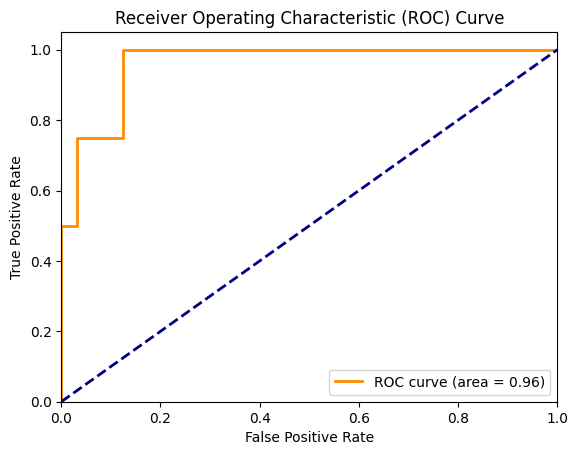


Cross-Validation Metrics for 'BMS-R':
Precision: 0.74
Recall: 0.74
F1 Score: 0.74
Confusion Matrix:
[[ 8  4  0  0  0  0  0  0  0  0]
 [ 2 12  0  0  1  1  0  0  0  0]
 [ 0  2  1  2  0  0  0  0  0  0]
 [ 0  0  0 16  4  0  0  0  0  0]
 [ 0  1  1  2  5  5  0  0  0  0]
 [ 0  0  0  1  1 26  1  0  4  0]
 [ 0  0  0  0  0  1 11  0  0  0]
 [ 0  0  0  0  0  1  0  6  0  0]
 [ 0  0  0  0  0  2  0  0 13  0]
 [ 0  0  0  0  0  0  0  0  1  9]]


In [ ]:
# LightGBM - L: 0.6429, R: 0.7143, with blanks - L:0.7222, R: 0.8056, for the following hyperparameters:
# Best Hyperparameters for 'BMS-L' (LightGBM): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
# Best Hyperparameters for 'BMS-R' (LightGBM): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# L: 0.75, R: 0.8056
# And for the following (default) hyperparameters (learning rate: 0.1, max_depth: -1, n_estimators: 100 - L: 0.7778, R: 0.7778
# Best Hyperparameters for 'BMS-L' (LightGBM): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400} L: 0.75
# Best Hyperparameters for 'BMS-R' (LightGBM): {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200} R: 0.7778

# X contains your feature data, and y contains multiple target columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the hyperparameters for 'BMS-L'
lgb_params_BMS_L = {
    'objective': 'multiclass',
    'num_class': 10,
    'random_state': 42,
    'verbose': -1,  # Set verbosity to suppress warnings (optional)
    'learning_rate': 0.01,  # Set the learning rate
    'max_depth': -1,  # Set the maximum depth of trees
    'n_estimators': 1000  # Set the number of estimators (trees)
}

# Create the LightGBM model for 'BMS-L' with the specified hyperparameters
lgb_model_BMS_L = LGBMClassifier(**lgb_params_BMS_L)

# Fit the model and make predictions as you did before
lgb_model_BMS_L.fit(X_train, y_train['BMS-L'])
lgb_y_pred_BMS_L = lgb_model_BMS_L.predict(X_test)
lgb_accuracy_BMS_L = accuracy_score(y_test['BMS-L'], lgb_y_pred_BMS_L)
print(f"LightGBM Accuracy for 'BMS-L': {lgb_accuracy_BMS_L}")

# Repeat the process for 'BMS-R' with its specific hyperparameters
lgb_params_BMS_R = {
    'objective': 'multiclass',
    'num_class': 10,
    'random_state': 42,
    'verbose': -1,  # Set verbosity to suppress warnings (optional)
    'learning_rate': 0.01,  # Set the learning rate
    'max_depth': -1,  # Set the maximum depth of trees
    'n_estimators': 1000  # Set the number of estimators (trees)
}

lgb_model_BMS_R = LGBMClassifier(**lgb_params_BMS_R)
lgb_model_BMS_R.fit(X_train, y_train['BMS-R'])
lgb_y_pred_BMS_R = lgb_model_BMS_R.predict(X_test)
lgb_accuracy_BMS_R = accuracy_score(y_test['BMS-R'], lgb_y_pred_BMS_R)
print(f"LightGBM Accuracy for 'BMS-R': {lgb_accuracy_BMS_R}")

# Calculate metrics for 'BMS-L'
print("Metrics for 'BMS-L':")
calculate_metrics(y_test['BMS-L'], lgb_y_pred_BMS_L)

# Plot ROC curve for 'BMS-L'
y_score_BMS_L = lgb_model_BMS_L.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test['BMS-L'], y_score_BMS_L)

# Implement k-fold cross-validation for 'BMS-L'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv_BMS_L = cross_val_predict(lgb_model_BMS_L, X_train, y_train['BMS-L'], cv=cv, method='predict')
print("Cross-Validation Metrics for 'BMS-L':")
calculate_metrics(y_train['BMS-L'], y_pred_cv_BMS_L)

# Calculate metrics for 'BMS-R'
print("\nMetrics for 'BMS-R':")
calculate_metrics(y_test['BMS-R'], lgb_y_pred_BMS_R)

# Plot ROC curve for 'BMS-R'
y_score_BMS_R = lgb_model_BMS_R.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test['BMS-R'], y_score_BMS_R)

# Implement k-fold cross-validation for 'BMS-R'
y_pred_cv_BMS_R = cross_val_predict(lgb_model_BMS_R, X_train, y_train['BMS-R'], cv=cv, method='predict')
print("\nCross-Validation Metrics for 'BMS-R':")
calculate_metrics(y_train['BMS-R'], y_pred_cv_BMS_R)

# both w 0.1,1, 500: 0.7222, 0.8056

In [ ]:
# CatBoost - L: 0.5, R: 0.7143, with blanks - L:0.7222, R: 0.6667, using following hyperparameters:
# Best Hyperparameters for 'BMS-L' (CatBoost): {'depth': 4, 'iterations': 300, 'learning_rate': 0.2}
# Best Hyperparameters for 'BMS-R' (CatBoost): {'depth': 4, 'iterations': 100, 'learning_rate': 0.2}
# L: 0.7222, R: 0.6944
# With initial hyperparameters - iterations: 1000, depth: 6, learning_rate: 0.1 --> L: 0.8333, R: 0.7222
# X contains your feature data, and y contains multiple target columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

# Initialize and train the CatBoost model for 'BMS-L'
catboost_model_BMS_L = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='MultiClass', random_state=42)
catboost_model_BMS_L.fit(X_train, y_train['BMS-L'], verbose=False)

# Make predictions on the test data for 'BMS-L'
catboost_y_pred_BMS_L = catboost_model_BMS_L.predict(X_test)

# Evaluate the model for 'BMS-L'
catboost_accuracy_BMS_L = accuracy_score(y_test['BMS-L'], catboost_y_pred_BMS_L)
print(f"CatBoost Accuracy for 'BMS-L': {catboost_accuracy_BMS_L}")

# Repeat the process for 'BMS-R'
catboost_model_BMS_R = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='MultiClass', random_state=42)
catboost_model_BMS_R.fit(X_train, y_train['BMS-R'], verbose=False)
catboost_y_pred_BMS_R = catboost_model_BMS_R.predict(X_test)
catboost_accuracy_BMS_R = accuracy_score(y_test['BMS-R'], catboost_y_pred_BMS_R)
print(f"CatBoost Accuracy for 'BMS-R': {catboost_accuracy_BMS_R}")

CatBoost Accuracy for 'BMS-L': 0.9166666666666666
CatBoost Accuracy for 'BMS-R': 0.7777777777777778


In [ ]:
# hist gradient boosting classifier: both training are 1 and test L is 0.7778 and R is 0.75
clf = HistGradientBoostingClassifier().fit(X_train, y_train['BMS-L'])

print("Training Score", clf.score(X_train, y_train['BMS-L']))
print("Test Score", clf.score(X_test, y_test['BMS-L']))

clf = HistGradientBoostingClassifier().fit(X_train, y_train['BMS-R'])

print("Training Score", clf.score(X_train, y_train['BMS-R']))
print("Test Score", clf.score(X_test, y_test['BMS-R']))

Training Score 1.0
Test Score 0.7777777777777778
Training Score 1.0
Test Score 0.75
